<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/Human_Faces_dataset_DCGAN_(128_64_32)_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Human Faces dataset DCGAN Example

In [ ]:
import numpy as np
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from matplotlib import pyplot as plt
from keras import backend
import time
from PIL import Image
import os
from tqdm import tqdm
import pickle
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to the image directory
dir_data = "/content/drive/MyDrive/Colab Notebooks/Datasets/Humans"
# path so save temp files
dir = '/content/drive/MyDrive/Colab Notebooks/temp/'

# setting image shape to 32x32
img_shape = (32, 32, 3)
# setting image shape to 64x64
img_shape = (64, 64, 3)
# setting image shape to 128x128
#img_shape = (128, 128, 3)

# listing out all file names
nm_imgs = np.sort(os.listdir(dir_data))
print('dataset shape:', nm_imgs.shape[0])

dataset shape: 7219


In [ ]:
nm_imgs[0]

'1 (1).jpeg'

In [ ]:
# defines the dimension variables
resize_img = (32,32)
fig_size = (2,1)
data_pkl = 'data32x32.pkl'
model_human = 'modelH32_'
weights_human = 'weightsH32_'
if img_shape[0] == 64:
  resize_img = (64,64)
  fig_size = (3,2)
  data_pkl = 'data64x64.pkl'
  model_human = 'modelH64_'
  weights_human = 'weightsH64_'
if img_shape[0] == 128:
  resize_img = (128,128)
  fig_size = (4,3)
  data_pkl = 'data128x128.pkl'
  model_human = 'modelH128_'
  weights_human = 'weightsH128_'

print(resize_img)
print(data_pkl)
print(model_human)
print(weights_human)

(64, 64)
data64x64.pkl
modelH64_
weightsH64_


In [ ]:
# load images from file
X_train = []
for file in tqdm(nm_imgs):
    try:
        img = Image.open(dir_data+'/'+file)
        img = img.convert('RGB')
        img = img.resize(resize_img)
        img = np.asarray(img)
        X_train.append(img)
    except:
        print("something went wrong")

X_train = np.array(X_train)
print('\nX_train shape:', X_train.shape)
print('min:', X_train.min(), 'max:', X_train.max())

  4%|▍         | 299/7219 [02:48<03:32, 32.57it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 7219/7219 [07:56<00:00, 15.16it/s]



X_train shape: (7219, 128, 128, 3)
min: 0 max: 255


In [ ]:
# save file X_train to google drive
try:
  output = open(dir + data_pkl, 'wb')
  pickle.dump(X_train, output)
  output.close()
  print('file ' + data_pkl + ' saved to drive!')
except:
  print('dir or file does not exist!')

In [ ]:
# load file X_train from google drive
try:
  pkl_file = open(dir + data_pkl, 'rb')
  X_train = pickle.load(pkl_file)
  pkl_file.close()
  print('X_train shape:', X_train.shape)
  print('min:', X_train.min(), 'max:', X_train.max())
except:
  print('dir or file does not exist!')

X_train shape: (7219, 64, 64, 3)
min: 0 max: 255


Pixel type: uint8
Number of dimensions: 3
Image size: (128, 128, 3)


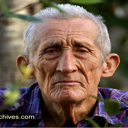

In [ ]:
im = X_train[2]
print('Pixel type:', im.dtype)
print('Number of dimensions:', im.ndim)
print('Image size:', im.shape)
pil_img = Image.fromarray(X_train[2])
newsize = (128, 128)
pil_img = pil_img.resize(newsize)
pil_img

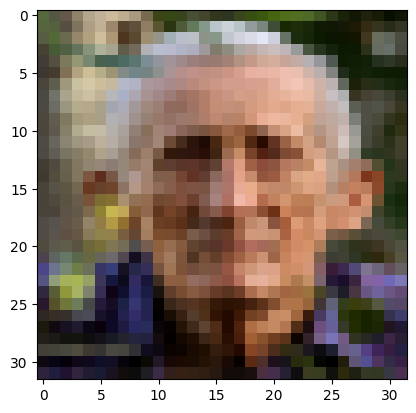

In [ ]:
plt.imshow(X_train[2])
plt.show()

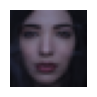

In [ ]:
# rotina para visualizar imagens aleatórias em sequência
n = 50  # nr de imagens a serem visualizadas
j = np.random.randint(len(X_train)-n)
for i in range(n):
  t = time.time()
  plt.figure(figsize = fig_size)
  plt.imshow(X_train[i+j])
  plt.axis('off')
  plt.show()
  while time.time() < (t + .8):
    pass
  display.clear_output(wait=True)

In [ ]:
# Function to visualize random Training Images
def show_dataset(X_train):
  j = np.random.randint(len(X_train)-60)
  fig = plt.figure(figsize=(10,7))
  for i in range(60):
    ax = fig.add_subplot(6, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i+j])
    plt.axis('off')
  #plt.tight_layout()
  plt.show()

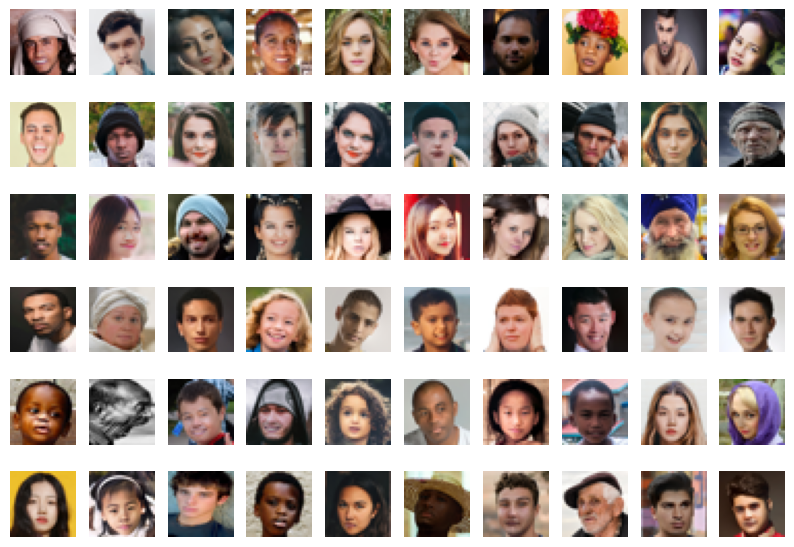

In [ ]:
show_dataset(X_train)

In [ ]:
# Rotina para salvar o modelo da rede treinada (modelo, pesos e bias) para predições futuras sem ter que treiná-lo novamente
def model_save(model, name):
  mod = str(name)
  model_json = model.to_json()
  try:
    #with open('/content/drive/MyDrive/Colab Notebooks/temp/modelH2'+ mod +'.json','w') as json_file:
    with open('/content/drive/MyDrive/Colab Notebooks/temp/' + model_human + mod +'.json','w') as json_file:
        json_file.write(model_json)
    #model.save_weights('/content/drive/MyDrive/Colab Notebooks/temp/weightsH2'+ mod + '.h5')
    model.save_weights('/content/drive/MyDrive/Colab Notebooks/temp/' + weights_human + mod + '.h5')
  except:
    print('drive canot be open to save files!')
    return

  print('Saved model ' + mod + ' to disk')

In [ ]:
# Resets all state generated by Keras
backend.clear_session()

In [ ]:
# define the standalone discriminator model
def define_discriminator():
  # in_shape=(32, 32, 3) or (64, 64, 3) or (128, 128, 3)
  in_shape = resize_img + (3,)
  model = Sequential(name='Discriminator')
  # normal
  model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))

  if resize_img[0] > 64:
    model.add(Dense(1024, activation='tanh'))
    model.add(Dropout(0.4))

  if resize_img[0] > 32:
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.4))

  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
# create the discriminator
d_model = define_discriminator()
# summarize the model
d_model.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)       

In [ ]:
 # compile model
def compile(model, name):
  # opt = Adam(learning_rate=0.0002, beta_1=0.5)
  opt = Adam(learning_rate=0.0001, beta_1=0.5, weight_decay=1e-8)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  print('done ' + name + ' compile')

In [ ]:
# compile model discriminator
compile(d_model, 'discriminator')

done discriminator compile


In [ ]:
# convert from unsigned ints to floats
X = X_train.astype('float32')
# scale from [0,255] to [-1,1]
dataset = (X - 127.5) / 127.5
print(dataset.shape)
print(dataset.min(), dataset.max())

(7219, 64, 64, 3)
-1.0 1.0


In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input, verbose=0)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential(name='Generator')
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    if resize_img[0] > 32:
    #   # upsample to 64x64 --> colocoado aqui para dimensões de 64x64 das figuras
      model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))

    if resize_img[0] > 64:
    #   # upsample to 128x128 --> colocoado aqui para dimensões de 128x128 das figuras
      model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))

    # output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

In [ ]:
# define the size of the latent space
latent_dim = 100
# define the generator model
g_model = define_generator(latent_dim)
# summarize the model
g_model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                              

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
# define GAN model: the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential(name='GAN')
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  return model

In [ ]:
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         1728387   
                                                                 
 Discriminator (Sequential)  (None, 1)                 4713217   
                                                                 
Total params: 6441604 (24.57 MB)
Trainable params: 1728387 (6.59 MB)
Non-trainable params: 4713217 (17.98 MB)
_________________________________________________________________


In [ ]:
# compile GAN model
compile(gan_model, 'GAN')

done GAN compile


In [ ]:
# create a plot of generated images
def plot_img(examples, n=8):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    fig = plt.figure(figsize=(9,9))
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    plt.show()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    # save plot
    plot_img(x_fake)
    # save models and weigths
    model_save(g_model, 'Generator')
    model_save(d_model, 'Discriminator')
    model_save(gan_model, 'GAN')

In [ ]:
# train the GAN: generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  time_init = time.time()
  print('start GAN training')
  # manually enumerate epochs
  for i in range(n_epochs):
    print('.', end = "")
    #t = time.time()
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss, _ = gan_model.train_on_batch(X_gan, y_gan)

    # evaluate the model performance, sometimes
    if i % 10 == 0:
      display.clear_output(wait=True)
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f, elapsed time:%ds' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss, int(time.time()-time_init)))

  print('end GAN training')

>Accuracy real: 79%, fake: 98%


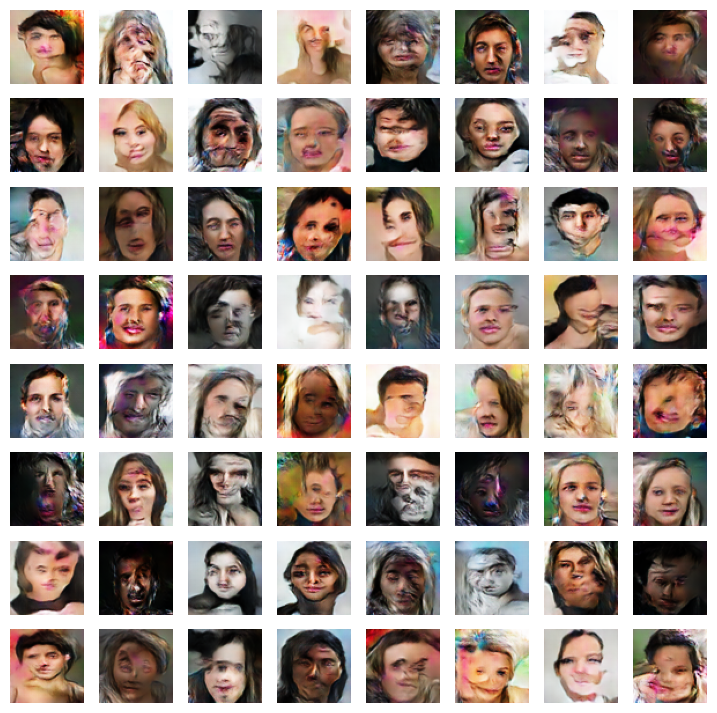

Saved model Generator to disk
Saved model Discriminator to disk
Saved model GAN to disk
>21, 56/56, d1=0.439, d2=0.216, g=0.000, elapsed time:351s
....

In [ ]:
# train model
#train(g_model, d_model, gan_model, dataset, latent_dim, 150, 256)
train(g_model, d_model, gan_model, dataset, latent_dim, 1000)

In [ ]:
# rotina para carregar os modelos das redes treinadas (modelo, pesos e bias)
# para predições futuras sem ter que treiná-lo novamente ou para reiniciar os treinamentos
def load_model(name):
  mod = str(name)
  try:
    # Load json and create model
    j_file = open('/content/drive/MyDrive/Colab Notebooks/temp/' + model_human + mod +'.json','r')
  except:
    print('file does not exist or drive is not open!')
    return

  load_model_json = j_file.read()
  j_file.close()
  loaded_model=model_from_json(load_model_json)
  try:
    # Load weights into new model
    loaded_model.load_weights('/content/drive/MyDrive/Colab Notebooks/temp/' + weights_human + mod + '.h5')
  except:
    print('file does not exist or drive is not open!')
    return

  print('Loaded model ' + mod + ' from disk')
  return loaded_model

In [ ]:
# carrego os modelos treinados
g_model = load_model('Generator')
d_model = load_model('Discriminator')
gan_model = load_model('GAN')

Loaded model Generator from disk
Loaded model Discriminator from disk
Loaded model GAN from disk


In [ ]:
compile(d_model, 'discriminator')
compile(gan_model, 'GAN')

done discriminator compile
done GAN compile


In [ ]:
# função para gerar as imagens fake com as pedições
def plot_generated_images(examples=50):
  noise = np.random.normal(0, 1, size=[examples, latent_dim])
  generated_images = g_model.predict(noise, verbose='None')
  discr_predict = d_model.predict(generated_images, verbose='None')
  #gen_images = generated_images.reshape(examples, 32, 32, 3)
  gen_images = generated_images.reshape(examples, resize_img[0], resize_img[0], 3)
  # scale from [-1,1] to [0,1]
  gen_images = (gen_images + 1) / 2.0
  dim=(10, 10)
  plt.figure(figsize=(13, 15))
  for i in range(gen_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_images[i])
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), size=10)
    plt.axis('off')
  #plt.tight_layout()

In [ ]:
# # função para plotar as imagens reais com as pedições
def plot_real_images(examples=50):
  X_real, _ = generate_real_samples(dataset, examples)
  discr_predict = d_model.predict(X_real, verbose='None')
  # scale from [-1,1] to [0,1]
  X_real = (X_real + 1) / 2.0
  dim=(10, 10)
  plt.figure(figsize=(13, 15))
  for i in range(X_real.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(X_real[i])
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), size=10)
    plt.axis('off')
  #plt.tight_layout()

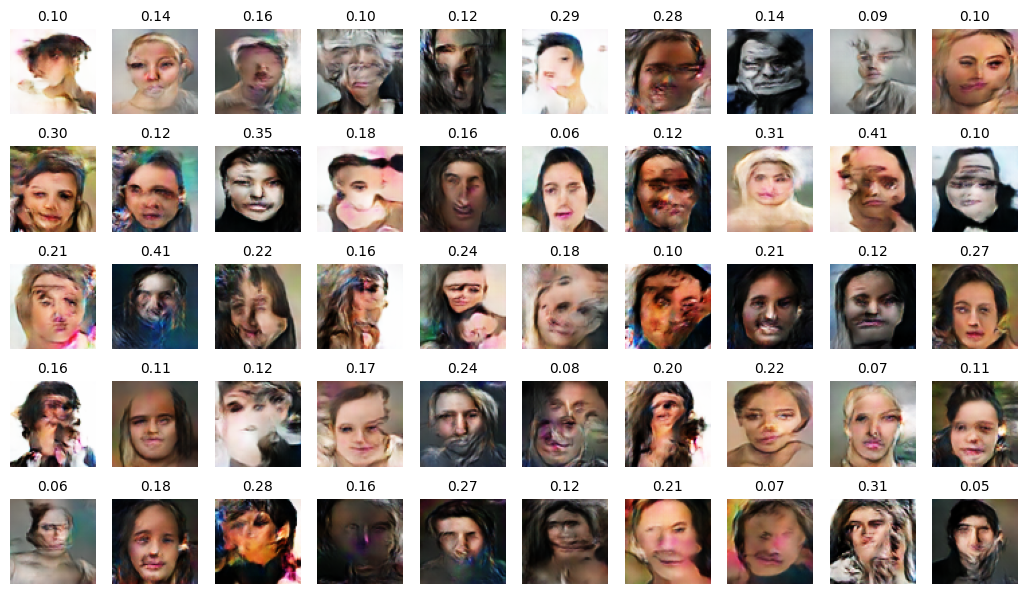

In [ ]:
plot_generated_images()

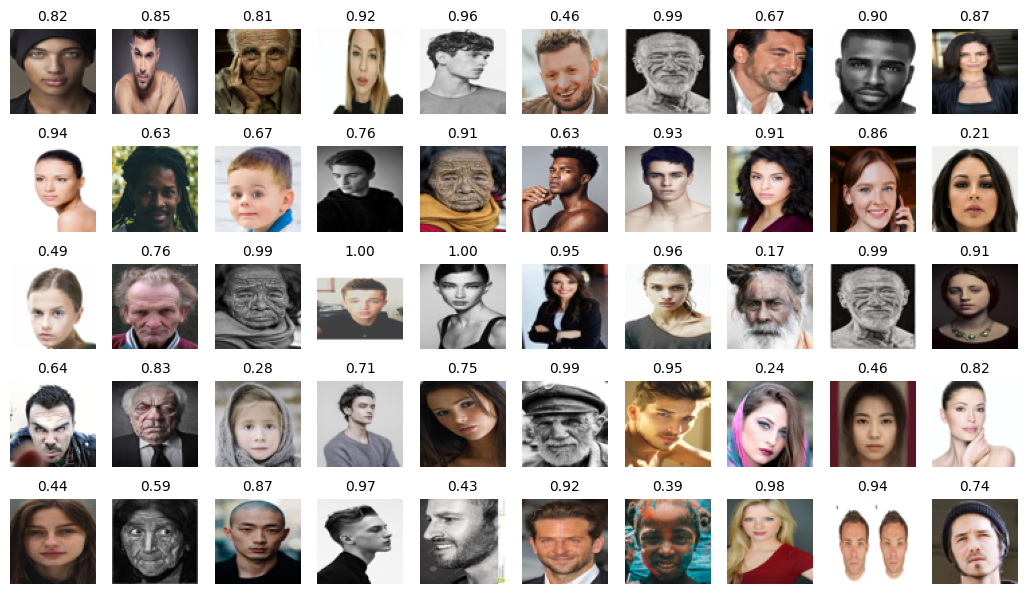

In [ ]:
plot_real_images()

##Referências

[1] [How to Develop a GAN to Generate CIFAR10](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

[2] https://www.tensorflow.org/tutorials/generative/dcgan

[3] https://pyimagesearch.com/2020/11/16/gans-with-keras-and-tensorflow/

[4] https://github.com/tensorflow/gan

[5] https://blog.paperspace.com/implementing-gans-in-tensorflow/

[6] https://pyimagesearch.com/2020/11/16/gans-with-keras-and-tensorflow/

[7] https://www.kaggle.com/code/nageshsingh/generate-realistic-human-face-using-gan

##Exercícios
1. Estudar e entender o princípio de funcionamento do otimizador Adam, os parâmetros beta e os demais parâmetros.
1. Treinar a GAN com o banco de imagens redimensionadas em 32x32, 64x64 e 128x128.
1. Comparar os resultados.
1. No gerador, inserir camadas densas MLP antes da camada final e verifique se a rede converge. Compare os resultados.
1. Change Latent Space. Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.
1. Batch Normalization. Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.
1. Label Smoothing. Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9 and add random noise, then review the effects on image quality and speed of training.
1. Model Configuration. Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the UpSampling2D layers in the generator.